# Hybrid Topic Discovery & Classification with AWS Integration

**Purpose**: Classify student questions against existing topics and discover new topics using hybrid approach.

**Data Flow**:
1. Load topics from Google Sheets
2. Load student questions from Langfuse CSV
3. Similarity classification (threshold-based)
4. Clustering for new topic discovery
5. Output parquet files to AWS S3

**Key Features**:
- AWS S3 for embeddings cache and outputs
- Environment-responsive configuration
- Comprehensive error logging
- Analytics outputs for Streamlit dashboard

## Install Dependencies

In [ ]:
!pip install -q openai pandas numpy scipy scikit-learn matplotlib seaborn tqdm umap-learn hdbscan bertopic backoff boto3 gspread oauth2client pyarrow fastparquet python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.6 MB/s eta 0:00:00


## Configuration

In [ ]:
# Processing settings
EVAL_MODE = "all"  # "sample" or "all"
SAMPLE_SIZE = 1000
SIMILARITY_THRESHOLD = 0.70
REPRESENTATIVE_QUESTION_METHOD = "centroid"  # "centroid" or "frequent"

# Model settings
EMBEDDING_MODEL = "text-embedding-3-small"
EMBEDDING_DIMENSIONS = 1536
GPT_MODEL = "gpt-5-nano"

# AWS S3 settings
S3_BUCKET = "byupathway-public"
S3_OUTPUT_PREFIX = "topic-modeling-data"
S3_CACHE_PREFIX = "embeddings-cache"
S3_REGION = "us-east-1"

# Clustering settings
UMAP_N_COMPONENTS = 5
HDBSCAN_MIN_CLUSTER_SIZE = 3
RANDOM_SEED = 42

# Google Sheets URL (This should come from Elder Edwards)
GOOGLE_SHEETS_URL = "https://docs.google.com/spreadsheets/d/1L3kOmE6mZEVotjUu2ZuLqir2rZ4c0yfNeeTuHwf3JQI/edit?gid=0#gid=0"

print("✅ Configuration loaded")
print(f"   Mode: {EVAL_MODE}, Threshold: {SIMILARITY_THRESHOLD}")
print(f"   S3 Bucket: {S3_BUCKET}")
print(f"   Embedding Model: {EMBEDDING_MODEL}")

✅ Configuration loaded
   Mode: all, Threshold: 0.7
   S3 Bucket: byupathway-public
   Embedding Model: text-embedding-3-small


## Environment Setup

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
import json
import pickle
from pathlib import Path
import time
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional, Any
import asyncio
import backoff
import re
import hashlib
import boto3
from botocore.exceptions import ClientError
import gspread
from oauth2client.service_account import ServiceAccountCredentials

# Detect environment
try:
    import google.colab
    IN_COLAB = True
    from google.colab import userdata
    print("🔧 Running in Google Colab")
except ImportError:
    IN_COLAB = False
    from dotenv import load_dotenv
    load_dotenv()
    print("🔧 Running locally")

# Load credentials
if IN_COLAB:
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
    AWS_ACCESS_KEY = userdata.get('AWS_ACCESS_KEY_ID')
    AWS_SECRET_KEY = userdata.get('AWS_SECRET_ACCESS_KEY')
    GOOGLE_SERVICE_ACCOUNT = userdata.get('GOOGLE_SERVICE_ACCOUNT_JSON')
else:
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
    AWS_ACCESS_KEY = os.getenv('AWS_ACCESS_KEY_ID')
    AWS_SECRET_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')
    GOOGLE_SERVICE_ACCOUNT = os.getenv('GOOGLE_SERVICE_ACCOUNT_JSON')

# Initialize OpenAI
from openai import OpenAI, AsyncOpenAI
client = OpenAI(api_key=OPENAI_API_KEY)
async_client = AsyncOpenAI(api_key=OPENAI_API_KEY)

# Initialize AWS S3
s3_client = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_KEY,
    region_name=S3_REGION
)

print("✅ Environment setup complete")

🔧 Running in Google Colab
✅ Environment setup complete


## Error Logger

In [ ]:
class ErrorLogger:
    def __init__(self):
        self.errors = []
        self.warnings = []
        self.rows_dropped = []
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    def log_error(self, stage: str, message: str, data: Any = None):
        entry = {"timestamp": datetime.now().isoformat(), "stage": stage, "message": message, "data": str(data)}
        self.errors.append(entry)
        print(f"❌ ERROR [{stage}]: {message}")

    def log_warning(self, stage: str, message: str, data: Any = None):
        entry = {"timestamp": datetime.now().isoformat(), "stage": stage, "message": message, "data": str(data)}
        self.warnings.append(entry)
        print(f"⚠️  WARNING [{stage}]: {message}")

    def log_dropped_row(self, stage: str, reason: str, row_data: Any):
        entry = {"timestamp": datetime.now().isoformat(), "stage": stage, "reason": reason, "row_data": str(row_data)}
        self.rows_dropped.append(entry)

    def get_summary(self):
        return {
            "total_errors": len(self.errors),
            "total_warnings": len(self.warnings),
            "total_dropped_rows": len(self.rows_dropped),
            "errors": self.errors,
            "warnings": self.warnings,
            "dropped_rows": self.rows_dropped
        }

    def save_to_file(self, filename: str):
        with open(filename, 'w') as f:
            json.dump(self.get_summary(), f, indent=2)
        print(f"📝 Error log saved: {filename}")
        return filename

error_logger = ErrorLogger()
print("✅ Error logger initialized")

✅ Error logger initialized


## AWS S3 Utilities

In [ ]:
@backoff.on_exception(
    backoff.expo,
    Exception,
    max_tries=5,
    max_time=30,
    giveup=lambda e: isinstance(e, (KeyboardInterrupt, SystemExit))
)
def upload_to_s3(local_path: str, s3_key: str, public: bool = True) -> bool:
    """Upload file to S3 with retry logic and exponential backoff

    Args:
        local_path: Local file path to upload
        s3_key: S3 key (path in bucket)
        public: Whether to set public-read ACL (default True)

    Returns:
        bool: True if successful, False otherwise
    """
    try:
        extra_args = {'ACL': 'public-read'} if public else {}
        s3_client.upload_file(local_path, S3_BUCKET, s3_key, ExtraArgs=extra_args)

        if public:
            url = f"https://{S3_BUCKET}.s3.amazonaws.com/{s3_key}"
            print(f"✅ Uploaded to S3: {url}")
        else:
            print(f"✅ Uploaded to S3: s3://{S3_BUCKET}/{s3_key}")

        return True
    except Exception as e:
        error_logger.log_error("S3_Upload", f"Failed to upload {local_path} after retries", e)
        return False

@backoff.on_exception(
    backoff.expo,
    Exception,
    max_tries=3,
    max_time=15,
    giveup=lambda e: isinstance(e, (KeyboardInterrupt, SystemExit))
)
def download_from_s3(s3_key: str, local_path: str) -> bool:
    """Download file from S3 with retry logic"""
    try:
        s3_client.download_file(S3_BUCKET, s3_key, local_path)
        return True
    except ClientError as e:
        if e.response['Error']['Code'] == '404':
            # File doesn't exist - don't retry
            return False
        error_logger.log_error("S3_Download", f"Failed to download {s3_key} after retries", e)
        return False

def delete_s3_folder(prefix: str):
    """Delete all objects with given prefix"""
    try:
        response = s3_client.list_objects_v2(Bucket=S3_BUCKET, Prefix=prefix)
        if 'Contents' in response:
            objects = [{'Key': obj['Key']} for obj in response['Contents']]
            s3_client.delete_objects(Bucket=S3_BUCKET, Delete={'Objects': objects})
            print(f"🗑️  Deleted {len(objects)} objects from s3://{S3_BUCKET}/{prefix}")
    except Exception as e:
        error_logger.log_error("S3_Delete", f"Failed to delete folder {prefix}", e)

print("✅ AWS S3 utilities ready (with retry logic)")

✅ AWS S3 utilities ready (with retry logic)


## Google Sheets Integration

In [ ]:
def read_topics_from_google_sheets(sheet_url: str) -> pd.DataFrame:
    """Read topics from Google Sheets with flexible column handling"""
    try:
        creds_dict = json.loads(GOOGLE_SERVICE_ACCOUNT)
        scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
        creds = ServiceAccountCredentials.from_json_keyfile_dict(creds_dict, scope)
        gc = gspread.authorize(creds)

        sheet = gc.open_by_url(sheet_url)
        worksheet = sheet.get_worksheet(0)
        data = worksheet.get_all_records()
        df = pd.DataFrame(data)

        # Handle both uppercase and lowercase column names
        column_mapping = {}
        for col in df.columns:
            col_lower = col.lower()
            if col_lower == 'topics' or col_lower == 'topic':
                column_mapping[col] = 'topic'
            elif col_lower == 'subtopics' or col_lower == 'subtopic':
                column_mapping[col] = 'subtopic'
            elif col_lower == 'questions' or col_lower == 'question':
                column_mapping[col] = 'question'

        df = df.rename(columns=column_mapping)

        required = ['topic', 'subtopic', 'question']
        if not all(col in df.columns for col in required):
            raise ValueError(f"Missing required columns. Found: {list(df.columns)}")

        df = df[required].dropna()
        print(f"✅ Loaded {len(df)} topics from Google Sheets")
        print(f"   Unique topics: {df['topic'].nunique()}, Unique subtopics: {df['subtopic'].nunique()}")
        return df

    except Exception as e:
        error_logger.log_error("GoogleSheets", "Failed to read topics", e)
        raise

print("✅ Google Sheets integration ready")

✅ Google Sheets integration ready


## Langfuse Data Cleaning

In [ ]:
def clean_langfuse_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean Langfuse CSV with kwargs error handling and metadata extraction.

    Extracts columns: timestamp, input, output, user_feedback, country, state, city,
    ip_address, user_language, is_suspicious
    """
    print(f"🧹 Cleaning {len(df)} rows from Langfuse...")

    cleaned_rows = []

    for idx, row in df.iterrows():
        try:
            cleaned_row = {}

            # 1. Extract timestamp
            cleaned_row['timestamp'] = row.get('timestamp', None)

            # 2. Extract input (question) - handle kwargs errors
            input_value = row.get('input')
            if pd.isna(input_value) or input_value == '':
                # Try to extract from kwargs (malformed rows)
                if 'kwargs' in df.columns and pd.notna(row.get('kwargs')):
                    try:
                        kwargs_data = json.loads(row['kwargs'])
                        messages = kwargs_data.get('data', {}).get('messages', [])
                        # First user message is the question
                        for msg in messages:
                            if msg.get('role') == 'user':
                                input_value = msg.get('content', '')
                                break
                    except (json.JSONDecodeError, KeyError, IndexError, TypeError) as e:
                        error_logger.log_dropped_row("LangfuseClean", "Invalid kwargs JSON", {"index": idx, "error": str(e)})
                        continue

            # Validate input is not empty
            if pd.isna(input_value) or str(input_value).strip() == '':
                error_logger.log_dropped_row("LangfuseClean", "Missing input", {"index": idx})
                continue

            cleaned_row['input'] = str(input_value).strip()

            # 3. Extract output - handle kwargs errors
            output_value = row.get('output')
            if pd.isna(output_value) or output_value == '':
                # Try to extract from kwargs (second assistant message)
                if 'kwargs' in df.columns and pd.notna(row.get('kwargs')):
                    try:
                        kwargs_data = json.loads(row['kwargs'])
                        messages = kwargs_data.get('data', {}).get('messages', [])
                        # Find assistant message (output)
                        for msg in messages:
                            if msg.get('role') == 'assistant':
                                output_value = msg.get('content', '')
                                break
                    except (json.JSONDecodeError, KeyError, IndexError, TypeError):
                        pass  # Output is optional, don't drop row

            cleaned_row['output'] = output_value if pd.notna(output_value) else None

            # 4. Extract user_feedback
            cleaned_row['user_feedback'] = row.get('user_feedback', None)

            # 5. Parse metadata JSON for country, state, city, ip, language, is_suspicious
            metadata_value = row.get('metadata')
            if pd.notna(metadata_value) and metadata_value != '':
                try:
                    metadata = json.loads(metadata_value) if isinstance(metadata_value, str) else metadata_value

                    # Extract geographic data
                    cleaned_row['country'] = metadata.get('country')
                    cleaned_row['state'] = metadata.get('state')
                    cleaned_row['city'] = metadata.get('city')
                    cleaned_row['ip_address'] = metadata.get('ip')
                    cleaned_row['user_language'] = metadata.get('user_language')

                    # Extract is_suspicious from security_validation
                    security_val = metadata.get('security_validation', {})
                    if isinstance(security_val, dict):
                        cleaned_row['is_suspicious'] = security_val.get('is_suspicious', False)
                    else:
                        cleaned_row['is_suspicious'] = False

                except (json.JSONDecodeError, TypeError, AttributeError) as e:
                    # Metadata parsing failed, set nulls
                    error_logger.log_error("LangfuseClean", f"Failed to parse metadata at row {idx}", e)
                    cleaned_row['country'] = None
                    cleaned_row['state'] = None
                    cleaned_row['city'] = None
                    cleaned_row['ip_address'] = None
                    cleaned_row['user_language'] = None
                    cleaned_row['is_suspicious'] = False
            else:
                # No metadata, set nulls
                cleaned_row['country'] = None
                cleaned_row['state'] = None
                cleaned_row['city'] = None
                cleaned_row['ip_address'] = None
                cleaned_row['user_language'] = None
                cleaned_row['is_suspicious'] = False

            cleaned_rows.append(cleaned_row)

        except Exception as e:
            error_logger.log_dropped_row("LangfuseClean", f"Unexpected error: {e}", {"index": idx})
            continue

    cleaned_df = pd.DataFrame(cleaned_rows)

    # Remove duplicates (same timestamp and input)
    if 'timestamp' in cleaned_df.columns and 'input' in cleaned_df.columns:
        before_dedup = len(cleaned_df)
        cleaned_df = cleaned_df.drop_duplicates(subset=['timestamp', 'input'], keep='first')
        after_dedup = len(cleaned_df)
        if before_dedup > after_dedup:
            print(f"🗑️  Removed {before_dedup - after_dedup} duplicate rows (same timestamp + input)")

    # Clean question prefixes (ACM Question)
    cleaned_df['input'] = cleaned_df['input'].apply(lambda x: clean_question(x) if pd.notna(x) else x)

    print(f"✅ Cleaned data: {len(cleaned_df)} rows ({len(df) - len(cleaned_df)} dropped)")
    print(f"   Columns: {list(cleaned_df.columns)}")
    print(f"   Country data: {cleaned_df['country'].notna().sum()} rows with country info")

    return cleaned_df

print("✅ Langfuse cleaning utilities ready")

✅ Langfuse cleaning utilities ready


## Question Preprocessing

In [ ]:
def clean_question(question: str) -> str:
    """Remove ACM prefixes and clean text"""
    if not isinstance(question, str):
        return str(question) if question is not None else ""

    pattern = r'^\s*\(ACMs?\s+[Qq]uestion\)\s*:?\s*'
    cleaned = re.sub(pattern, '', question, flags=re.IGNORECASE).strip()
    return cleaned if cleaned else question

def preprocess_dataframe(df: pd.DataFrame, question_col: str) -> pd.DataFrame:
    """Apply cleaning to question column"""
    df = df.copy()
    df[question_col] = df[question_col].apply(clean_question)
    return df

print("✅ Question preprocessing ready")

✅ Question preprocessing ready


## S3 Embeddings Cache

In [ ]:
def get_cache_key(text: str, model: str) -> str:
    """Generate S3 cache key for text"""
    text_hash = hashlib.md5(text.encode()).hexdigest()[:12]
    return f"{S3_CACHE_PREFIX}/{model}/{text_hash}.pkl"

def load_embedding_from_s3(text: str, model: str) -> Optional[List[float]]:
    """Load cached embedding from S3"""
    cache_key = get_cache_key(text, model)
    local_path = f"/tmp/{cache_key.split('/')[-1]}"

    if download_from_s3(cache_key, local_path):
        try:
            with open(local_path, 'rb') as f:
                embedding = pickle.load(f)
            # Clean up temp file after reading
            try:
                os.unlink(local_path)
            except:
                pass
            return embedding
        except Exception as e:
            # Clean up corrupted cache file
            try:
                os.unlink(local_path)
            except:
                pass
    return None

def save_embedding_to_s3(text: str, model: str, embedding: List[float]):
    """Save embedding to S3 cache with retry logic"""
    cache_key = get_cache_key(text, model)
    local_path = f"/tmp/{cache_key.split('/')[-1]}"

    try:
        # Write to local temp file
        with open(local_path, 'wb') as f:
            pickle.dump(embedding, f)

        # Upload to S3 (with retry logic from upload_to_s3)
        # Use public=False for cache files (no need for public access)
        success = upload_to_s3(local_path, cache_key, public=False)

        # Clean up temp file
        try:
            os.unlink(local_path)
        except:
            pass

        return success
    except Exception as e:
        # Clean up on failure
        try:
            if os.path.exists(local_path):
                os.unlink(local_path)
        except:
            pass
        # Don't log - cache failures are expected and handled gracefully
        return False

print("✅ S3 embeddings cache ready (with retry logic)")

✅ S3 embeddings cache ready (with retry logic)


## Embedding Generation

In [ ]:
def get_embeddings_batch(texts: List[str], model: str = EMBEDDING_MODEL, batch_size: int = 1000) -> List[List[float]]:
    """Generate embeddings with S3 caching"""
    cleaned_texts = [clean_question(t) for t in texts]
    embeddings = []
    cache_hits = 0
    api_calls = 0

    print(f"🔄 Processing {len(cleaned_texts)} texts...")

    for i in tqdm(range(0, len(cleaned_texts), batch_size), desc="Batches"):
        batch_texts = cleaned_texts[i:i+batch_size]
        batch_embeddings = []
        uncached_texts = []
        uncached_indices = []

        # Check S3 cache
        for j, text in enumerate(batch_texts):
            cached = load_embedding_from_s3(text, model)
            if cached:
                batch_embeddings.append(cached)
                cache_hits += 1
            else:
                batch_embeddings.append(None)
                uncached_texts.append(text)
                uncached_indices.append(j)

        # Generate uncached embeddings
        if uncached_texts:
            try:
                response = client.embeddings.create(model=model, input=uncached_texts)
                new_embeddings = [d.embedding for d in response.data]
                api_calls += len(uncached_texts)

                for idx, emb in zip(uncached_indices, new_embeddings):
                    batch_embeddings[idx] = emb
                    save_embedding_to_s3(batch_texts[idx], model, emb)
            except Exception as e:
                error_logger.log_error("Embeddings", f"Batch failed", e)
                for idx in uncached_indices:
                    batch_embeddings[idx] = [0.0] * EMBEDDING_DIMENSIONS

        embeddings.extend(batch_embeddings)

    print(f"✅ Complete! Cache: {cache_hits}/{len(embeddings)} ({cache_hits/len(embeddings)*100:.1f}%), API: {api_calls}")
    return embeddings

print("✅ Embedding generation ready")

✅ Embedding generation ready


## Load Data

In [ ]:
# Load topics from Google Sheets
print("📊 Loading topics from Google Sheets...")
topics_df = read_topics_from_google_sheets(GOOGLE_SHEETS_URL)
topics_df = preprocess_dataframe(topics_df, 'question')

# Upload Langfuse CSV
if IN_COLAB:
    from google.colab import files
    print("\n📂 Upload Langfuse CSV:")
    uploaded = files.upload()
    langfuse_filename = list(uploaded.keys())[0]
else:
    langfuse_filename = "notebook/langfuse_traces_10_08_25.csv"

# Load and clean Langfuse data
print(f"\n📊 Loading Langfuse data from {langfuse_filename}...")
langfuse_df = pd.read_csv(langfuse_filename)
langfuse_clean = clean_langfuse_data(langfuse_df)

# Create questions dataframe with all metadata columns preserved
questions_df = langfuse_clean[['input', 'timestamp', 'country', 'state', 'city', 'output', 'user_feedback', 'ip_address', 'user_language', 'is_suspicious']].copy()
questions_df = questions_df.rename(columns={'input': 'question'})
questions_df = preprocess_dataframe(questions_df, 'question')

print(f"\n📊 DATA LOADED:")
print(f"   Topics: {len(topics_df)} ({topics_df['topic'].nunique()} unique)")
print(f"   Questions: {len(questions_df)}")
print(f"   With metadata: country={questions_df['country'].notna().sum()}, timestamp={questions_df['timestamp'].notna().sum()}")
print(f"   Errors: {error_logger.get_summary()['total_errors']}")
print(f"   Dropped rows: {error_logger.get_summary()['total_dropped_rows']}")

📊 Loading topics from Google Sheets...
✅ Loaded 120 topics from Google Sheets
   Unique topics: 59, Unique subtopics: 118

📂 Upload Langfuse CSV:


Saving langfuse_traces_10_08_25.csv to langfuse_traces_10_08_25.csv

📊 Loading Langfuse data from langfuse_traces_10_08_25.csv...
🧹 Cleaning 4600 rows from Langfuse...
✅ Cleaned data: 4600 rows (0 dropped)
   Columns: ['timestamp', 'input', 'output', 'user_feedback', 'country', 'state', 'city', 'ip_address', 'user_language', 'is_suspicious']
   Country data: 519 rows with country info

📊 DATA LOADED:
   Topics: 120 (59 unique)
   Questions: 4600
   With metadata: country=519, timestamp=4600
   Errors: 0
   Dropped rows: 0


## Prepare Evaluation Dataset

In [ ]:
if EVAL_MODE == "sample":
    eval_df = questions_df.sample(n=min(SAMPLE_SIZE, len(questions_df)), random_state=RANDOM_SEED).copy()
    print(f"📝 Sample mode: {len(eval_df)} questions")
else:
    eval_df = questions_df.copy()
    print(f"📝 Full mode: {len(eval_df)} questions")

# Cost estimate
total_tokens = (len(topics_df) + len(eval_df)) * 50
embedding_cost = (total_tokens / 1_000_000) * 0.02
print(f"💰 Estimated cost: ${embedding_cost:.4f} (embeddings only)")

📝 Full mode: 4600 questions
💰 Estimated cost: $0.0047 (embeddings only)


## Similarity Classification

In [ ]:
def classify_by_similarity(questions_df: pd.DataFrame, topics_df: pd.DataFrame, threshold: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Classify questions by similarity to existing topics - preserves all metadata columns"""

    print(f"\n🎯 Similarity Classification (threshold: {threshold})")

    # Generate embeddings
    print(f"📊 Generating topic embeddings...")
    topic_embeddings = get_embeddings_batch(topics_df['question'].tolist())
    topics_df = topics_df.copy()
    topics_df['embedding'] = topic_embeddings

    print(f"📊 Generating question embeddings...")
    question_embeddings = get_embeddings_batch(questions_df['question'].tolist())

    # Classify
    similar = []
    remaining = []

    print(f"🔍 Classifying {len(questions_df)} questions...")
    for idx, (_, row) in enumerate(tqdm(questions_df.iterrows(), total=len(questions_df))):
        question = row['question']
        q_emb = question_embeddings[idx]

        if not q_emb or len(q_emb) != EMBEDDING_DIMENSIONS:
            row_data = row.to_dict()
            row_data['embedding'] = [0.0]*EMBEDDING_DIMENSIONS
            remaining.append(row_data)
            continue

        best_sim = 0
        best_match = None

        for _, topic_row in topics_df.iterrows():
            t_emb = topic_row['embedding']
            if t_emb and len(t_emb) == EMBEDDING_DIMENSIONS:
                sim = 1 - cosine(q_emb, t_emb)
                if sim > best_sim:
                    best_sim = sim
                    best_match = topic_row

        if best_sim >= threshold and best_match is not None:
            row_data = row.to_dict()
            row_data['matched_topic'] = best_match['topic']
            row_data['matched_subtopic'] = best_match['subtopic']
            row_data['similarity_score'] = best_sim
            similar.append(row_data)
        else:
            row_data = row.to_dict()
            row_data['embedding'] = q_emb
            remaining.append(row_data)

    similar_df = pd.DataFrame(similar)
    remaining_df = pd.DataFrame(remaining)

    print(f"\n✅ Classification complete:")
    print(f"   Similar: {len(similar_df)} ({len(similar_df)/len(questions_df)*100:.1f}%)")
    print(f"   Remaining: {len(remaining_df)} ({len(remaining_df)/len(questions_df)*100:.1f}%)")

    return similar_df, remaining_df

similar_df, remaining_df = classify_by_similarity(eval_df, topics_df, SIMILARITY_THRESHOLD)


🎯 Similarity Classification (threshold: 0.7)
📊 Generating topic embeddings...
🔄 Processing 120 texts...


Batches: 100%|██████████| 1/1 [00:29<00:00, 29.37s/it]


✅ Complete! Cache: 120/120 (100.0%), API: 0
📊 Generating question embeddings...
🔄 Processing 4600 texts...


Batches: 100%|██████████| 5/5 [18:34<00:00, 222.97s/it]


✅ Complete! Cache: 4600/4600 (100.0%), API: 0
🔍 Classifying 4600 questions...


100%|██████████| 4600/4600 [03:10<00:00, 24.20it/s]



✅ Classification complete:
   Similar: 716 (15.6%)
   Remaining: 3884 (84.4%)


## Clustering for New Topics

In [ ]:
clustered_df = None
topic_model = None

if len(remaining_df) > 0:
    print(f"\n🎯 Clustering {len(remaining_df)} remaining questions...")

    from umap import UMAP
    from hdbscan import HDBSCAN
    from bertopic import BERTopic

    embeddings = np.array(remaining_df['embedding'].tolist())

    # UMAP
    print(f"🔄 UMAP reduction to {UMAP_N_COMPONENTS} dimensions...")
    umap_model = UMAP(n_components=UMAP_N_COMPONENTS, min_dist=0.0, metric='cosine', random_state=RANDOM_SEED)
    reduced = umap_model.fit_transform(embeddings)

    # HDBSCAN
    print(f"🔄 HDBSCAN clustering (min_size={HDBSCAN_MIN_CLUSTER_SIZE})...")
    hdbscan_model = HDBSCAN(min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE, metric="euclidean", cluster_selection_method="eom")
    clusters = hdbscan_model.fit_predict(reduced)

    n_clusters = len([c for c in np.unique(clusters) if c != -1])
    n_noise = sum(clusters == -1)
    print(f"✅ Found {n_clusters} clusters, {n_noise} noise points")

    if n_clusters > 0:
        # BERTopic
        topic_model = BERTopic(embedding_model=None, umap_model=umap_model, hdbscan_model=hdbscan_model, verbose=False)
        topics, probs = topic_model.fit_transform(remaining_df['question'].tolist(), embeddings)

        clustered_df = remaining_df.copy()
        clustered_df['cluster_id'] = clusters
        clustered_df['topic_id'] = topics
        clustered_df = clustered_df[clustered_df['cluster_id'] != -1]

        print(f"✅ Clustered {len(clustered_df)} questions into {n_clusters} topics")
else:
    print("\n✅ All questions matched existing topics - no clustering needed")


🎯 Clustering 3884 remaining questions...


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


🔄 UMAP reduction to 5 dimensions...
🔄 HDBSCAN clustering (min_size=3)...
✅ Found 290 clusters, 703 noise points
✅ Clustered 3181 questions into 290 topics


## Generate Topic Names with GPT

In [ ]:
topic_names = {}

if clustered_df is not None and len(clustered_df) > 0:
    print(f"\n🤖 Generating topic names with {GPT_MODEL}...")

    async def generate_topic_name(questions: List[str], keywords: str = "") -> str:
        """Generate a topic name using GPT-5 for a cluster of questions"""

        # Limit to top 10 questions for context (like insights)
        sample_questions = questions[:10]
        questions_text = "\n".join([f"- {q}" for q in sample_questions])

        prompt = f"""
Based on the following student questions and keywords, generate a concise, descriptive topic name.

QUESTIONS:
{questions_text}

KEYWORDS: {keywords}

Instructions:
- Your answer must be ONLY the topic name (2–8 words), no extra text.
- It should clearly describe the shared theme of the questions.
- Avoid generic labels like "General Questions" or "Miscellaneous."
- Do not include "Topic name:" or quotation marks.
- Use simple, natural English that sounds clear to a student or teacher.

Example:
Questions:
- When does registration open?
- What are the fall 2025 enrollment deadlines?
Keywords: registration, deadlines

Topic name: Fall 2025 Registration Deadlines

Now generate the topic name for the questions above:
"""

        try:
            messages = [
                {"role": "system", "content": "You are an expert at creating clear, descriptive topic names for student question categories."},
                {"role": "user", "content": prompt}
            ]

            # GPT-5 specific configuration (NO temperature parameter!)
            response = await async_client.chat.completions.create(
                model=GPT_MODEL,
                messages=messages,
                max_completion_tokens=1000  # Use max_completion_tokens for GPT-5, not max_tokens
            )

            topic_name = response.choices[0].message.content.strip()

            # Clean up the response
            topic_name = topic_name.replace("Topic name:", "").strip()
            topic_name = topic_name.strip('\"\'')

            if not topic_name:
                topic_name = f"Topic: {keywords[:50]}" if keywords else f"Question Group {hash(str(questions[:3])) % 1000}"

            return topic_name

        except Exception as e:
            error_logger.log_error("TopicNaming", f"GPT failed: {str(e)}", e)
            # Fallback to keyword-based name
            fallback_name = f"Topic: {keywords[:50]}" if keywords else f"Question Group {hash(str(questions[:3])) % 1000}"
            return fallback_name

    async def process_all_clusters():
        tasks = []
        cluster_ids = []

        for cluster_id, group in clustered_df.groupby('cluster_id'):
            questions = group['question'].tolist()
            # Extract keywords from BERTopic if available
            keywords = group['topic_keywords'].iloc[0] if 'topic_keywords' in group.columns else ""

            tasks.append(generate_topic_name(questions, keywords))
            cluster_ids.append(cluster_id)

        names = await asyncio.gather(*tasks)
        return dict(zip(cluster_ids, names))

    topic_names = await process_all_clusters()
    clustered_df['topic_name'] = clustered_df['cluster_id'].map(topic_names)

    print(f"✅ Generated {len(topic_names)} topic names")
    for cid, name in list(topic_names.items())[:5]:
        count = len(clustered_df[clustered_df['cluster_id'] == cid])
        print(f"   {name} ({count} questions)")


🤖 Generating topic names with gpt-5-nano...
✅ Generated 290 topic names
   Activity Tracker Definition and Usage (12 questions)
   PathwayConnect Registration, Courses, and Holds (15 questions)
   US Student Support Phone Number and Hours (7 questions)
   Global Services Contact Information (16 questions)
   Holds on Student Accounts (24 questions)


## Generate Output Files

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print(f"\n📁 Generating output files...")

# File 1: Similar questions
file1 = f"similar_questions_{timestamp}.parquet"
if len(similar_df) > 0:
    output1 = similar_df[['question', 'matched_topic', 'matched_subtopic', 'similarity_score']].copy()
    output1.columns = ['question', 'existing_topic', 'existing_subtopic', 'similarity_score']
    output1 = output1.sort_values('similarity_score', ascending=False)
else:
    output1 = pd.DataFrame(columns=['question', 'existing_topic', 'existing_subtopic', 'similarity_score'])

# Add metadata
output1.attrs['metadata'] = {
    'timestamp': timestamp,
    'threshold': SIMILARITY_THRESHOLD,
    'total_questions': len(output1),
    'default_visible_columns': ['question', 'existing_topic', 'existing_subtopic', 'similarity_score']
}
output1.to_parquet(file1)
print(f"✅ {file1}: {len(output1)} rows")

# File 2: New topics
file2 = f"new_topics_{timestamp}.parquet"
if clustered_df is not None and len(clustered_df) > 0:
    cluster_summary = clustered_df.groupby('cluster_id').agg({
        'topic_name': 'first',
        'question': ['first', 'count']
    }).reset_index()
    cluster_summary.columns = ['cluster_id', 'topic_name', 'representative_question', 'question_count']
    output2 = cluster_summary[['topic_name', 'representative_question', 'question_count']].sort_values('question_count', ascending=False)
else:
    output2 = pd.DataFrame(columns=['topic_name', 'representative_question', 'question_count'])

output2.attrs['metadata'] = {
    'timestamp': timestamp,
    'total_topics': len(output2),
    'default_visible_columns': ['topic_name', 'representative_question', 'question_count']
}
output2.to_parquet(file2)
print(f"✅ {file2}: {len(output2)} rows")

# File 3: All questions review WITH METADATA
file3 = f"pathway_questions_review_{timestamp}.parquet"
review_data = []

# Metadata columns to preserve
metadata_cols = ['timestamp', 'country', 'state', 'city', 'output', 'user_feedback', 'ip_address', 'user_language', 'is_suspicious']

if len(similar_df) > 0:
    for _, row in similar_df.iterrows():
        record = {
            'question': row['question'],
            'topic_name': f"{row['matched_topic']} | {row['matched_subtopic']}",
            'classification': 'existing',
            'confidence': row['similarity_score']
        }
        # Add metadata columns
        for col in metadata_cols:
            record[col] = row.get(col, None)
        review_data.append(record)

if clustered_df is not None and len(clustered_df) > 0:
    for _, row in clustered_df.iterrows():
        record = {
            'question': row['question'],
            'topic_name': row['topic_name'],
            'classification': 'new',
            'confidence': 0.5
        }
        # Add metadata columns
        for col in metadata_cols:
            record[col] = row.get(col, None)
        review_data.append(record)

if len(remaining_df) > len(clustered_df) if clustered_df is not None else len(remaining_df) > 0:
    clustered_questions = set(clustered_df['question']) if clustered_df is not None else set()
    for _, row in remaining_df.iterrows():
        if row['question'] not in clustered_questions:
            record = {
                'question': row['question'],
                'topic_name': 'Other',
                'classification': 'uncategorized',
                'confidence': 0.0
            }
            # Add metadata columns
            for col in metadata_cols:
                record[col] = row.get(col, None)
            review_data.append(record)

output3 = pd.DataFrame(review_data)
output3.attrs['metadata'] = {
    'timestamp': timestamp,
    'total_questions': len(output3),
    'default_visible_columns': ['question', 'timestamp', 'country', 'state', 'topic_name', 'classification']
}
output3.to_parquet(file3)
print(f"✅ {file3}: {len(output3)} rows")
print(f"   Columns: {list(output3.columns)}")
print(f"   With country data: {output3['country'].notna().sum()} rows")

# File 4: Topic distribution analytics
file4 = f"topic_distribution_{timestamp}.parquet"
topic_dist = output3.groupby(['topic_name', 'classification']).size().reset_index(name='count')
topic_dist = topic_dist.sort_values('count', ascending=False)
topic_dist.attrs['metadata'] = {
    'timestamp': timestamp,
    'total_topics': len(topic_dist),
    'default_visible_columns': ['topic_name', 'classification', 'count']
}
topic_dist.to_parquet(file4)
print(f"✅ {file4}: {len(topic_dist)} rows")

# Error log
error_log_file = f"error_log_{timestamp}.json"
with open(error_log_file, 'w') as f:
    json.dump(error_logger.get_summary(), f, indent=2)
print(f"✅ {error_log_file}: error summary")

# Create output_files list for S3 upload
output_files = [file1, file2, file3, file4, error_log_file]

print(f"\n📦 OUTPUT FILES GENERATED:")
print(f"   1. {file1} - Questions matched to existing topics")
print(f"   2. {file2} - New topic clusters discovered")
print(f"   3. {file3} - Complete review with ALL METADATA")
print(f"   4. {file4} - Topic distribution analytics")
print(f"   5. {error_log_file} - Error log")


📁 Generating output files...
✅ similar_questions_20251009_125131.parquet: 716 rows
✅ new_topics_20251009_125131.parquet: 290 rows
✅ pathway_questions_review_20251009_125131.parquet: 4595 rows
   Columns: ['question', 'topic_name', 'classification', 'confidence', 'timestamp', 'country', 'state', 'city', 'output', 'user_feedback', 'ip_address', 'user_language', 'is_suspicious']
   With country data: 519 rows
✅ topic_distribution_20251009_125131.parquet: 370 rows
✅ error_log_20251009_125131.json: error summary

📦 OUTPUT FILES GENERATED:
   1. similar_questions_20251009_125131.parquet - Questions matched to existing topics
   2. new_topics_20251009_125131.parquet - New topic clusters discovered
   3. pathway_questions_review_20251009_125131.parquet - Complete review with ALL METADATA
   4. topic_distribution_20251009_125131.parquet - Topic distribution analytics
   5. error_log_20251009_125131.json - Error log


## Upload to S3

In [ ]:
# Skip ACL if you don't have PutObjectAcl permission
# Use this if you can upload without ACL but not with public-read

print(f"\n☁️  Uploading to S3 (without public ACL)...")

# Delete old files
try:
    delete_s3_folder(S3_OUTPUT_PREFIX)
except Exception as e:
    print(f"⚠️  Could not delete old files: {e}")

# Upload new files WITHOUT public-read ACL
uploaded = []
failed = []

for filepath in output_files:
    if not os.path.exists(filepath):
        print(f"❌ File not found: {filepath}")
        failed.append(filepath)
        continue

    file_size = os.path.getsize(filepath)
    print(f"📤 Uploading {filepath} ({file_size:,} bytes)...")

    s3_key = f"{S3_OUTPUT_PREFIX}/{filepath}"

    try:
        # Use public=False to skip ACL (if you don't have PutObjectAcl permission)
        if upload_to_s3(filepath, s3_key, public=False):
            # Note: URL won't be publicly accessible without ACL
            url = f"s3://{S3_BUCKET}/{s3_key}"
            uploaded.append(url)
            print(f"   ✅ Success: {url}")
        else:
            failed.append(filepath)
            print(f"   ❌ Failed: {filepath}")
    except Exception as e:
        print(f"   ❌ Exception: {str(e)}")
        failed.append(filepath)

print(f"\n📊 UPLOAD SUMMARY:")
print(f"   ✅ Successful: {len(uploaded)}/{len(output_files)}")
print(f"   ❌ Failed: {len(failed)}/{len(output_files)}")

if uploaded:
    print(f"\n✅ Uploaded files (private - not publicly accessible):")
    for url in uploaded:
        print(f"   {url}")
    print(f"\n💡 TIP: Files are uploaded but not public. Your Streamlit app can access them with AWS credentials.")

if failed:
    print(f"\n❌ Failed files:")
    for f in failed:
        print(f"   {f}")


☁️  Uploading to S3 (without public ACL)...
🗑️  Deleted 5 objects from s3://byupathway-public/topic-modeling-data
📤 Uploading similar_questions_20251009_125131.parquet (36,059 bytes)...
✅ Uploaded to S3: s3://byupathway-public/topic-modeling-data/similar_questions_20251009_125131.parquet
   ✅ Success: s3://byupathway-public/topic-modeling-data/similar_questions_20251009_125131.parquet
📤 Uploading new_topics_20251009_125131.parquet (31,256 bytes)...
✅ Uploaded to S3: s3://byupathway-public/topic-modeling-data/new_topics_20251009_125131.parquet
   ✅ Success: s3://byupathway-public/topic-modeling-data/new_topics_20251009_125131.parquet
📤 Uploading pathway_questions_review_20251009_125131.parquet (1,514,207 bytes)...
✅ Uploaded to S3: s3://byupathway-public/topic-modeling-data/pathway_questions_review_20251009_125131.parquet
   ✅ Success: s3://byupathway-public/topic-modeling-data/pathway_questions_review_20251009_125131.parquet
📤 Uploading topic_distribution_20251009_125131.parquet (13,9

## Analysis & Visualization

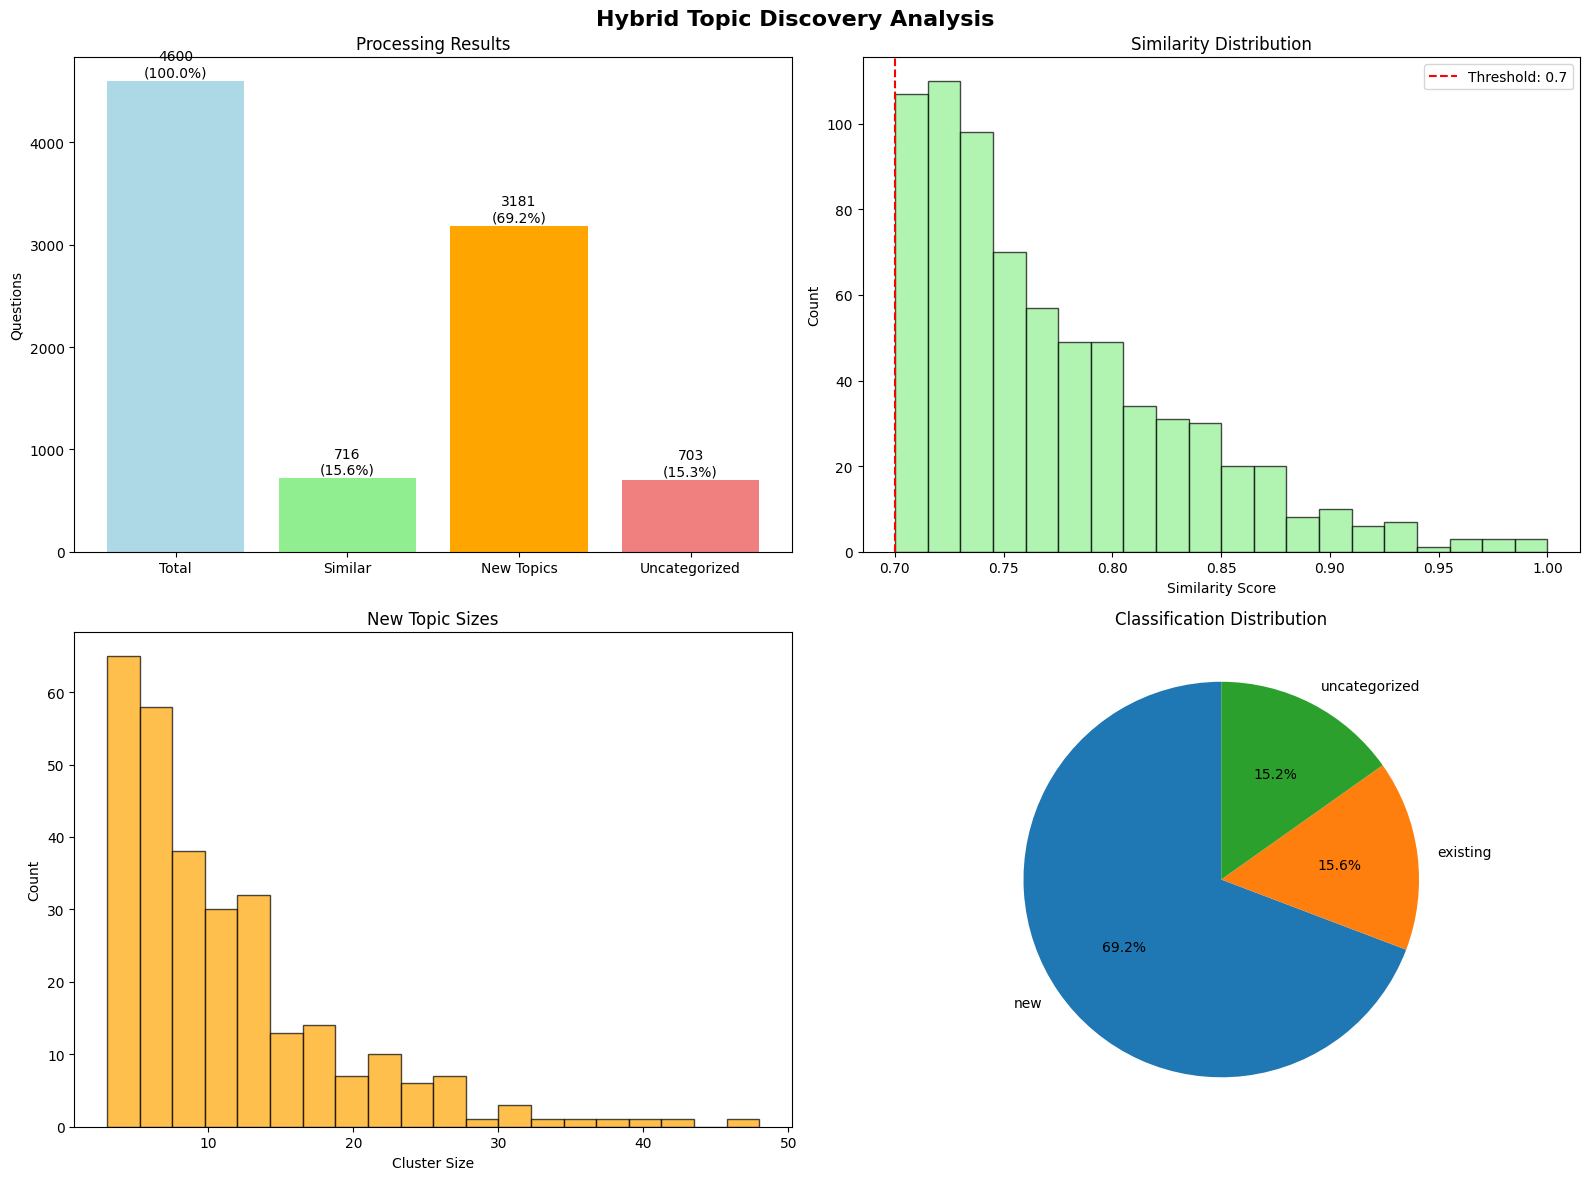


📊 SUMMARY:
   Total processed: 4600
   Similar to existing: 716 (15.6%)
   New topics: 290
   Errors: 0
   Warnings: 0

✅ COMPLETE! Files uploaded to S3.


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Hybrid Topic Discovery Analysis', fontsize=16, fontweight='bold')

# 1. Processing pipeline
pipeline = ['Total', 'Similar', 'New Topics', 'Uncategorized']
counts = [
    len(eval_df),
    len(similar_df),
    len(clustered_df) if clustered_df is not None else 0,
    len(eval_df) - len(similar_df) - (len(clustered_df) if clustered_df is not None else 0)
]
axes[0,0].bar(pipeline, counts, color=['lightblue', 'lightgreen', 'orange', 'lightcoral'])
axes[0,0].set_title('Processing Results')
axes[0,0].set_ylabel('Questions')
for i, (label, count) in enumerate(zip(pipeline, counts)):
    axes[0,0].text(i, count + max(counts)*0.01, f"{count}\n({count/len(eval_df)*100:.1f}%)", ha='center')

# 2. Similarity distribution
if len(similar_df) > 0:
    axes[0,1].hist(similar_df['similarity_score'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0,1].axvline(SIMILARITY_THRESHOLD, color='red', linestyle='--', label=f'Threshold: {SIMILARITY_THRESHOLD}')
    axes[0,1].set_xlabel('Similarity Score')
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_title('Similarity Distribution')
    axes[0,1].legend()
else:
    axes[0,1].text(0.5, 0.5, 'No similar questions', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Similarity Distribution')

# 3. Cluster sizes
if clustered_df is not None and len(clustered_df) > 0:
    cluster_sizes = clustered_df['cluster_id'].value_counts().values
    axes[1,0].hist(cluster_sizes, bins=min(20, len(cluster_sizes)), alpha=0.7, color='orange', edgecolor='black')
    axes[1,0].set_xlabel('Cluster Size')
    axes[1,0].set_ylabel('Count')
    axes[1,0].set_title('New Topic Sizes')
else:
    axes[1,0].text(0.5, 0.5, 'No clusters', ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('New Topic Sizes')

# 4. Topic distribution pie
pie_data = output3['classification'].value_counts()
if len(pie_data) > 0:
    axes[1,1].pie(pie_data.values, labels=pie_data.index, autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Classification Distribution')
else:
    axes[1,1].text(0.5, 0.5, 'No data', ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Classification Distribution')

plt.tight_layout()
plt.show()

print("\n📊 SUMMARY:")
print(f"   Total processed: {len(eval_df)}")
print(f"   Similar to existing: {len(similar_df)} ({len(similar_df)/len(eval_df)*100:.1f}%)")
print(f"   New topics: {len(topic_names)}")
print(f"   Errors: {error_logger.get_summary()['total_errors']}")
print(f"   Warnings: {error_logger.get_summary()['total_warnings']}")
print(f"\n✅ COMPLETE! Files uploaded to S3.")

In [ ]:
print(f"\n📊 QUESTIONS DATA SUMMARY:")
print(f"   Total rows: {len(questions_df)}")
if 'timestamp' in questions_df.columns:
    print(f"   Rows with distinct timestamps: {questions_df['timestamp'].nunique()}")
else:
    print(f"   'timestamp' column not found in questions_df.")


📊 QUESTIONS DATA SUMMARY:
   Total rows: 4600
   Rows with distinct timestamps: 4600
